# Bayesian Linear Regression 
Computational bayes final project.  
Nathan Yee  
Uma Desai  

First example to gain understanding is taken from Cypress Frankenfeld.
http://allendowney.blogspot.com/2015/04/two-hour-marathon-by-2041-probably.html

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf
import thinkplot
import pandas as pd
import matplotlib.pyplot as plt

Load data from csv file

In [2]:
df = pd.read_csv('ageVsHeight.csv', skiprows=0, delimiter='\t')
df

,age,height
0,18,76.1
1,19,77.0
2,20,78.1
3,21,78.2
4,22,78.8
5,23,79.7
6,24,79.9
7,25,81.1
8,26,81.2
9,27,81.8


Create x and y vectors. x is the ages, y is the heights

In [3]:
ages = np.array(df['age'])
heights = np.array(df['height'])

Abstract least squares function using a function

In [4]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

Use the leastSquares function to get a slope and intercept. Then use the slope and intercept to calculate the size of our alpha and beta ranges

In [5]:
slope, intercept = leastSquares(ages, heights)
print(slope, intercept)
alpha_range = .005 * intercept
beta_range = .005 * slope

0.634965034965 64.9283216783


Visualize the slope and intercept on the same plot as the data so make sure it is working correctly

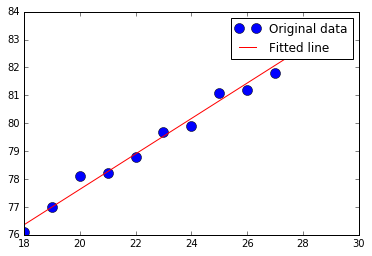

In [6]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
plt.legend()
plt.show()

Make range of alphas (intercepts), betas (slopes), and sigmas (errors)

In [7]:
alphas = np.linspace(intercept - alpha_range, intercept + alpha_range, 10)
betas = np.linspace(slope - beta_range, slope + beta_range, 10)
sigmas = np.linspace(2, 4, 10)

# alphas = np.linspace(intercept * (1 - alpha_range),
#                      intercept * (1 + alpha_range),
#                      5)
# betas = np.linspace(slope * (1 - beta_range),
#                     slope * (1 + beta_range),
#                     5)
# sigmas = np.linspace(.1, .2, 5)

Turn those alphas, betas, and sigmas into our hypotheses

In [8]:
hypos = ((alpha, beta, sigma) for alpha in alphas 
         for beta in betas for sigma in sigmas)

Make data

In [9]:
data = [(age, height) for age in ages for height in heights]

Next make age class where likelihood is calculated based on error from data

In [10]:
class leastSquaresHypos(Suite):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (ages Vs height) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for age, measured_height in data:
            hypothesized_height = slope * age + intercept
            error = measured_height - hypothesized_height
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood
        

In [11]:
LeastSquaresHypos = leastSquaresHypos(hypos)

In [12]:
for item in data:
    LeastSquaresHypos.Update([item])

In [13]:
LeastSquaresHypos[LeastSquaresHypos.MaximumLikelihood()]

0.00886058492084809

In [14]:
def getHeights(hypo_samples, random_months):
    random_heights = np.zeros(len(random_months))
    for i in range(len(random_heights)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_months[i]
        random_heights[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_heights

def getRandomData(start_month, end_month, n, LeastSquaresHypos):
    """
    n - number of samples
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_months = np.random.uniform(start_month, end_month, n)
    random_heights = getHeights(random_hypos, random_months)
    return random_months, random_heights

In [15]:
random_months, random_heights = getRandomData(29, 40, 100, LeastSquaresHypos)

In [16]:
hori_range, hori_step = np.linspace(29, 40 , retstep=True)
vert_range, vert_step = np.linspace(75, 100, retstep=True)

buckets = dict()
keys = [(hori, vert) for hori in hori_range for vert in vert_range]

for key in keys:
    buckets[key] = 0
    
for month, height in zip(random_months, random_heights):
        for key in buckets:
            if month > key[0] - hori_step and month < key[0] + hori_step:
                if height > key[1] - vert_step and month < key[1] + vert_step:
                    buckets[key] += 1
                    break # can only fit in a single bucket

In [17]:
pcolor_months = []
pcolor_heights = []
pcolor_intensities = []
for key in buckets:
    pcolor_months.append(key[0])
    pcolor_heights.append(key[1])
    pcolor_intensities.append(buckets[key])   
    
print(len(pcolor_months), len(pcolor_heights), len(pcolor_intensities))

2500 2500 2500


ValueError: not enough values to unpack (expected 2, got 1)

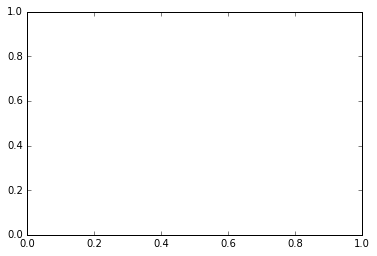

In [18]:
plt.pcolormesh(pcolor_months, pcolor_heights, pcolor_intensities, cmap='RdBu')
plt.show()

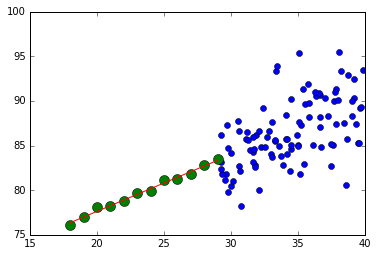

In [20]:
plt.plot(random_months, random_heights, 'o', label='Random Sampling')
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
# plt.legend()
plt.show()

In [ ]:
help(plt.pcolor)

In [18]:
dx, dy = 3, 3
y, x = np.mgrid[slice(29, 40 + dy, dy),
                slice(75, 100 + dx, dx)]

In [19]:
y.shape

(5, 10)

In [20]:
x.shape

(5, 10)

In [21]:
z=y*x*0
z.shape

(5, 10)

In [22]:
x

array([[ 75,  78,  81,  84,  87,  90,  93,  96,  99, 102],
       [ 75,  78,  81,  84,  87,  90,  93,  96,  99, 102],
       [ 75,  78,  81,  84,  87,  90,  93,  96,  99, 102],
       [ 75,  78,  81,  84,  87,  90,  93,  96,  99, 102],
       [ 75,  78,  81,  84,  87,  90,  93,  96,  99, 102]])

In [23]:
y

array([[29, 29, 29, 29, 29, 29, 29, 29, 29, 29],
       [32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
       [35, 35, 35, 35, 35, 35, 35, 35, 35, 35],
       [38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 41]])

In [24]:
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

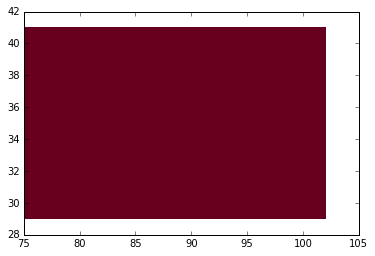

In [25]:
plt.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)

In [26]:
from matplotlib.mlab import griddata

# use your x,y and z arrays here
x = pcolor_months
y = pcolor_heights
z = pcolor_intensities

yy, xx = np.meshgrid(y,x)
zz = griddata(x,y,z,xx,yy, interp='linear')

In [27]:
for i in range(len(xx)):
    for j in range(len(xx)):

SyntaxError: unexpected EOF while parsing (<ipython-input-27-092a067c1032>, line 2)

In [189]:
range(len(xx))

range(0, 2500)

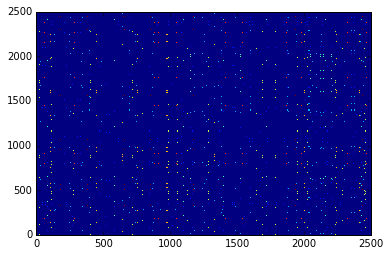

In [162]:
plt.pcolormesh(zz)

In [163]:
zz

masked_array(data =
 [[4.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 2.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 2.0 ..., 0.0 0.0 0.0]
 ..., 
 [0.0 0.0 0.0 ..., -2.842170943040401e-14 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = 1e+20)

In [174]:
# use your x,y and z arrays here
x = np.random.randint(1,30, 10)
y = np.random.randint(1,30, 10)
z = np.random.randint(1,30, 10)

yy, xx = np.meshgrid(y,x)
zz = griddata(x,y,z,xx,yy, interp='linear')
print(x)
print(zz)

[ 6  4 18 13 25  1 20 12 29 20]
[[16.0 24.540540540540537 -- 21.869565217391298 -- 19.325242718446603 -- --
  21.337837837837835 16.982905982905983]
 [20.0 25.0 -- -- -- 19.995145631067963 -- -- 23.125 19.375]
 [24.030075187969928 13.846153846153854 5.000000000000014 12.07692307692308
  -- 15.305825242718447 7.555555555555557 5.851851851851862
  19.15384615384616 23.85470085470085]
 [20.68421052631579 23.63157894736842 -- 23.999999999999996 --
  16.980582524271846 12.967741935483872 5.612903225806448
  22.526315789473685 20.99145299145299]
 [12.252252252252248 2.7521367521367495 -- -- 10.0 10.450450450450447 -- --
  8.059829059829056 12.027027027027017]
 [-- -- -- -- -- 21.0 -- -- -- --]
 [23.23076923076924 9.07692307692308 -- 7.307692307692307 --
  14.635922330097088 2.000000000000014 -- 14.384615384615387 25.0]
 [20.015037593984964 23.162162162162158 -- 23.695652173913047 --
  17.315533980582526 12.478260869565219 5.0 21.857142857142858
  20.418803418803417]
 [-- -- -- -- -- -- -- --